In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [45]:
# Constants
MIDI_NOTES = {
    0: "C-1", 1: "C#-1", 2: "D-1", 3: "D#-1", 4: "E-1", 5: "F-1", 6: "F#-1", 7: "G-1", 8: "G#-1", 9: "A-1", 10: "A#-1", 11: "B-1",
    12: "C0", 13: "C#0", 14: "D0", 15: "D#0", 16: "E0", 17: "F0", 18: "F#0", 19: "G0", 20: "G#0", 21: "A0", 22: "A#0", 23: "B0",
    24: "C1", 25: "C#1", 26: "D1", 27: "D#1", 28: "E1", 29: "F1", 30: "F#1", 31: "G1", 32: "G#1", 33: "A1", 34: "A#1", 35: "B1",
    36: "C2", 37: "C#2", 38: "D2", 39: "D#2", 40: "E2", 41: "F2", 42: "F#2", 43: "G2", 44: "G#2", 45: "A2", 46: "A#2", 47: "B2",
    48: "C3", 49: "C#3", 50: "D3", 51: "D#3", 52: "E3", 53: "F3", 54: "F#3", 55: "G3", 56: "G#3", 57: "A3", 58: "A#3", 59: "B3",
    60: "C4", 61: "C#4", 62: "D4", 63: "D#4", 64: "E4", 65: "F4", 66: "F#4", 67: "G4", 68: "G#4", 69: "A4", 70: "A#4", 71: "B4",
    72: "C5", 73: "C#5", 74: "D5", 75: "D#5", 76: "E5", 77: "F5", 78: "F#5", 79: "G5", 80: "G#5", 81: "A5", 82: "A#5", 83: "B5",
    84: "C6", 85: "C#6", 86: "D6", 87: "D#6", 88: "E6", 89: "F6", 90: "F#6", 91: "G6", 92: "G#6", 93: "A6", 94: "A#6", 95: "B6",
    96: "C7", 97: "C#7", 98: "D7", 99: "D#7", 100: "E7", 101: "F7", 102: "F#7", 103: "G7", 104: "G#7", 105: "A7", 106: "A#7", 107: "B7",
    108: "C8", 109: "C#8", 110: "D8", 111: "D#8", 112: "E8", 113: "F8", 114: "F#8", 115: "G8", 116: "G#8", 117: "A8", 118: "A#8", 119: "B8",
    120: "C9", 121: "C#9", 122: "D9", 123: "D#9", 124: "E9", 125: "F9", 126: "F#9", 127: "G9"
}

Y_PLOT_MIN = 36
Y_PLOT_MAX = 85

In [3]:
### PART 1: Data Visualization of song midi data

# add/delete and format columns
def clean_data(file_path):
    data = pd.read_csv(file_path)
    data = data.drop(columns=['pitch_bend'])
    data['pitch_name'] = data['pitch_midi'].map(MIDI_NOTES)

    # repeat last data point to show the end of the song
    first_entry = data.iloc[0].copy()
    first_entry['start_time_s'] = data.iloc[0]['end_time_s']
    first_entry_df = pd.DataFrame([first_entry])
    data = pd.concat([first_entry_df, data], ignore_index=True)

    return data

In [4]:
# plot midi of song over time
# and shade overlapping optimal range for user
def plot_pitch_over_time(data, title, voice_part):
    plt.figure(figsize=(16, 9))
    plt.title(title)
    plt.grid(True)
    plt.plot(np.array(data['start_time_s']), np.array(data['pitch_midi']), marker='o', linestyle='-', color='b')
    plt.legend(['note pitches of song over time'])
    
    # x-axis
    X_MIN = 0
    X_MAX = int(data['start_time_s'].max()) + 1  # round up
    plt.xlabel('Note Time (s)')
    plt.xlim(X_MIN, X_MAX)

    # voice part bounds
    if voice_part == 'soprano':
        Y_VOICE_MIN = 59
        Y_VOICE_MID = 70
        Y_VOICE_MAX = 81
    elif voice_part == 'alto':
        Y_VOICE_MIN = 52
        Y_VOICE_MID = 63
        Y_VOICE_MAX = 74
    elif voice_part == 'tenor':
        Y_VOICE_MIN = 47
        Y_VOICE_MID = 58
        Y_VOICE_MAX = 69
    elif voice_part == 'baritone':
        Y_VOICE_MIN = 43
        Y_VOICE_MID = 54
        Y_VOICE_MAX = 65
    else:
        Y_VOICE_MIN = 55
        Y_VOICE_MID = 61
        Y_VOICE_MAX = 67

    # y-axis
    Y_PLOT_MIN = 36
    Y_PLOT_MAX = 85
    plt.ylabel('Note Pitch')
    plt.ylim(Y_PLOT_MIN, Y_PLOT_MAX)
    y_ticks = range(Y_PLOT_MIN, Y_PLOT_MAX)
    y_labels = [MIDI_NOTES[num] for num in y_ticks]
    plt.yticks(ticks=y_ticks, labels=y_labels)

    # Set up custom function for shade class
    NUM_SHADED_REGIONS = 100
    color_grad = ['#00FF00', '#FFFF00', '#FF0000'] # Green to Yellow to Red
    color_map = LinearSegmentedColormap.from_list("custom_gradient", color_grad)

    class CustomNorm(Normalize):
        def __call__(self, value, clip=None):
            norm_value = np.sqrt((value - self.vmin) / (self.vmax - self.vmin)) # CUSTOM normalization FUNCTION HERE
            return np.clip(norm_value, 0, 1)  # Ensure it is in the range [0, 1]

    # top shade
    y_top = np.linspace(Y_VOICE_MID, Y_VOICE_MAX, NUM_SHADED_REGIONS)
    custom_norm_top = CustomNorm(vmin=Y_VOICE_MID, vmax=Y_VOICE_MAX)
    for i in range(NUM_SHADED_REGIONS):
        plt.fill_betweenx(y_top[i:i+2], X_MIN, X_MAX, color=color_map(custom_norm_top(y_top[i])))

    # bottom shade
    y_bottom = np.linspace(Y_VOICE_MIN, Y_VOICE_MID, NUM_SHADED_REGIONS)
    custom_norm_bottom = CustomNorm(vmin=Y_VOICE_MID, vmax=Y_VOICE_MIN)
    for i in range(NUM_SHADED_REGIONS):
        plt.fill_betweenx(y_bottom[i:i+2], X_MIN, X_MAX, color=color_map(custom_norm_bottom(y_bottom[i])))

    # final result!
    plt.show()
    return




In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics

# show frequency (amount of times) of frequencies (pitches/notes) within song
def plot_pitch_frequency(data):
    data['duration'] = data['end_time_s'] - data['start_time_s']

    # aggregate total duration by pitch_midi
    pitch_duration = data.groupby('pitch_midi')['duration'].sum().reset_index()
    pitch_duration['duration'] /= pitch_duration['duration'].sum()
    print(pitch_duration)

    # plot the distribution of total time for each pitch
    plt.figure(figsize=(16, 9))
    plt.title('Distribution of Total Time by MIDI Pitch')
    plt.xlabel('Pitch (MIDI)')
    plt.ylabel('Percentage of total time (%)')

    y_ticks = np.linspace(0, 1, 21)
    y_labels = [str(int((y * 100))) + "%" for y in y_ticks]
    plt.yticks(ticks=y_ticks, labels=y_labels)

    # convert midi_note labels to note letter names
    x_ticks = range(Y_PLOT_MIN, Y_PLOT_MAX)
    x_labels = [MIDI_NOTES[num] for num in x_ticks]
    plt.xticks(ticks=x_ticks, labels=x_labels)

    # plot user input voice distribution
    Y_VOICE_MIN = 52
    Y_VOICE_MID = 63
    Y_VOICE_MAX = 74
    x_axis = np.arange(Y_VOICE_MIN, Y_VOICE_MAX, 0.01)
    mean = statistics.mean(x_axis)
    sd = statistics.stdev(x_axis)
    norm_plot = norm.pdf(x_axis, mean, sd)
    plt.plot(x_axis, norm_plot)
    plt.fill_between(x_axis, norm_plot)

    plt.bar(pitch_duration['pitch_midi'], pitch_duration['duration'], color='r')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


    return




In [138]:
# Plot visualizations on "happy birthday"
# The input midi file is the output of audio file fed through AI voice stem separation tool
hbd_path = os.getcwd() + '/Python projects/Songmatch' + '/Happy_Birthday_Cleaned.csv'
hbd_data = clean_data(hbd_path)
print(hbd_data.head())
print(hbd_data.tail())

   start_time_s  end_time_s  pitch_midi  velocity pitch_name
0     15.531527   15.531527          72       106         C5
1     14.393749   15.531527          72       106         C5
2     13.753917   14.393749          74       104         D5
3     13.092148   13.765527          72       101         C5
4     12.441989   13.092148          76       102         E5
    start_time_s  end_time_s  pitch_midi  velocity pitch_name
24      1.998200    2.648359          72       102         C5
25      1.346757    2.044640          67       100         G4
26      0.696599    1.358367          69        97         A4
27      0.534059    0.998458          67        71         G4
28      0.046440    0.534059          67       108         G4


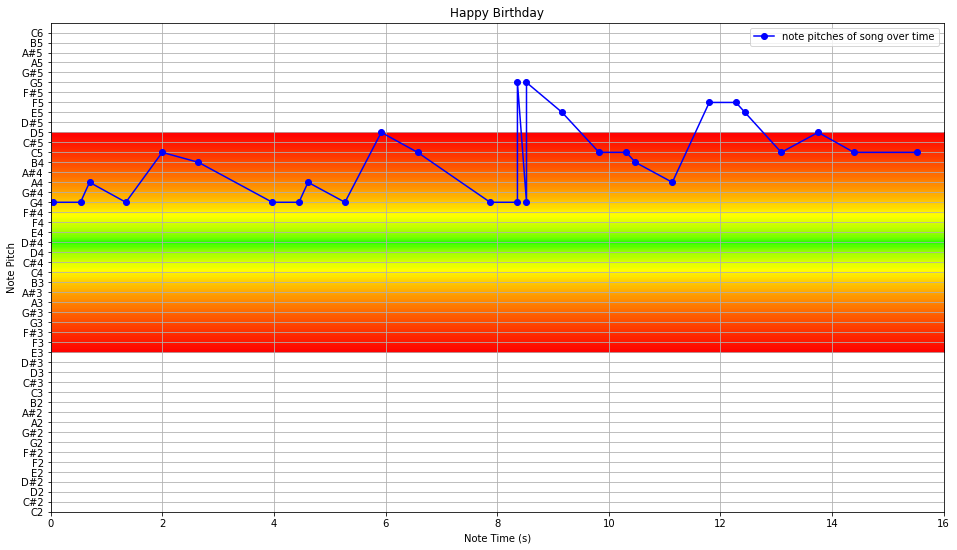

In [139]:
plot_pitch_over_time(data=hbd_data, title='Happy Birthday', voice_part='alto')


   pitch_midi  duration
0          67  0.262554
1          69  0.119050
2          71  0.114205
3          72  0.258941
4          74  0.076982
5          76  0.078905
6          77  0.038145
7          79  0.051219


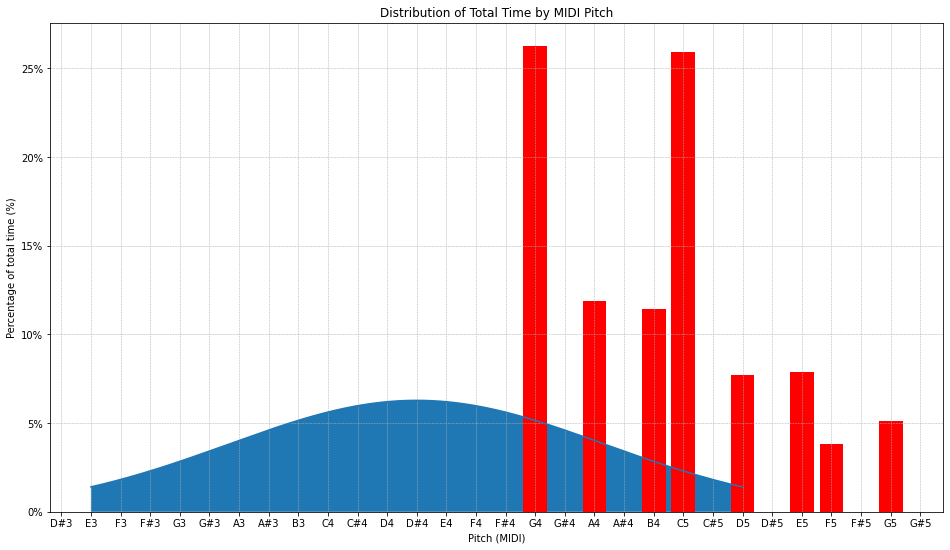

In [140]:
plot_pitch_frequency(hbd_data)

In [132]:
### PART 2: Web Scraping of current Billboard charts

import requests
from bs4 import BeautifulSoup

URL = "https://www.billboard.com/charts/hot-100/"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")


Top Songs today
1. A Bar Song (Tipsy) by Shaboozey
2. I Had Some Help by Post Malone Featuring Morgan Wallen
3. Not Like Us by Kendrick Lamar
4. Espresso by Sabrina Carpenter
5. Birds Of A Feather by Billie Eilish


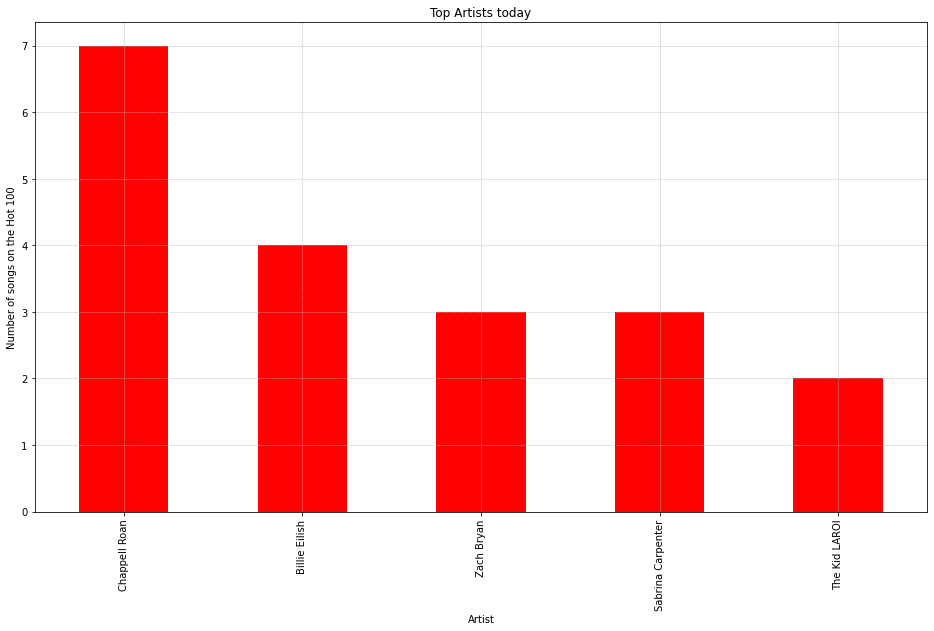

In [192]:
# locate song titles 
top_song = soup.find_all("li", class_="o-chart-results-list__item // lrv-u-flex-grow-1 lrv-u-flex lrv-u-flex-direction-column lrv-u-justify-content-center lrv-u-border-b-1 u-border-b-0@mobile-max lrv-u-border-color-grey-light lrv-u-padding-l-1@mobile-max")
all_songs = soup.find_all("li", class_="o-chart-results-list__item // lrv-u-flex-grow-1 lrv-u-flex lrv-u-flex-direction-column lrv-u-justify-content-center lrv-u-border-b-1 u-border-b-0@mobile-max lrv-u-border-color-grey-light lrv-u-padding-l-050 lrv-u-padding-l-1@mobile-max")
all_songs.insert(0, top_song[0])
all_songs = [s.text.replace('\t', '').split('\n') for s in all_songs]
all_songs = [[i for i in s if i] for s in all_songs]

song_info = {}
song_info["song_titles"] = [s[0] for s in all_songs]
song_info["artists"] = [s[1] for s in all_songs]

print("Top Songs today")
for i in range(5):
    print("{}. {} by {}".format(i + 1, song_info["song_titles"][i], song_info["artists"][i]))

df = pd.DataFrame(song_info)
artist_counts = df['artists'].value_counts().head(5)

plt.figure(figsize=(16, 9))
plt.title('Top Artists today')
plt.ylabel('Number of songs on the Hot 100')
artist_counts.plot(kind='bar', color='red')
plt.xlabel('Artist')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
    